# Optimierung und Evaluierung des Sequential bow Modells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import seaborn as sn
from wordcloud import WordCloud

from hyperopt import Trials, STATUS_OK, tpe

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Activation
from keras.regularizers import l2, l1
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import load_model

from hyperas import optim
from hyperas.distributions import choice, uniform, normal, qlognormal, randint

from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


## How are the Hyperparameter distributed

### Strukture

size of first and second hidden layer

In [ ]:
x = np.round(np.random.lognormal(7,0.5,10000)/10)*10
plt.hist(x,bins=100)
plt.xlim(0,5000)
plt.show()

size of third hidden layer

In [ ]:
x = np.round(np.random.lognormal(4,0.5,10000)/1)*1
plt.hist(x,bins=100)
plt.show()

### Regularization

In [ ]:
x =np.random.uniform(0,0.1,10000)
plt.hist(x,bins=100)
plt.show()

## Data preparation

In [2]:
def data_bow():
    x_test = np.genfromtxt("../build/preprocessed/bow_X_test.txt")
    x_train = np.genfromtxt("../build/preprocessed/bow_X_train.txt")
    y_test = np.genfromtxt("../build/preprocessed/bow_y_test.txt")
    y_train = np.genfromtxt("../build/preprocessed/bow_y_train.txt")
    return x_train, y_train, x_test, y_test

## Model creation

In [ ]:
def model_structure(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense({{qlognormal(7,0.5,10)}}, input_dim=dim))
    model.add(Activation('relu'))
    
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{qlognormal(7,0.5,10)}}))
        model.add(Activation('relu'))
        
    model.add(Dense({{qlognormal(4,0.5,1)}}))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='adam')

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_training(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(int(np.abs(1187.5872913047178)), input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(int(np.abs(-1475.2916969518506))))
    model.add(Activation('relu'))    
    model.add(Dense(261))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss={{choice(['hinge','binary_crossentropy','squared_hinge'])}}, metrics=['accuracy'],
                  optimizer={{choice(['adam','AdaDelta','Adagrad'])}})

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_regularization(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(int(np.abs(1187.5872913047178)), kernel_regularizer=l1({{uniform(0,0.1)}}), input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(int(np.abs(-1475.2916969518506)),kernel_regularizer=l2({{uniform(0,0.1)}})))
    model.add(Activation('relu'))    
    model.add(Dense(261,kernel_regularizer=l2({{uniform(0,0.1)}})))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='Adagrad')

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

## Optimization with hyperopt
Algorithm: Tree of Parzen Estimators
Optimierung in 3 Schritten:
    - Struktur (Tiefe (2 oder 3 hidden Layers) und Breite)
    - Training (loss function und optimizer)
    - Regularizierung ( L1 für die erste Layer und L2 für 2 und 3)

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_structure,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_struct.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_training,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_training.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_regularization,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=80,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_regularization.hdf5')

## Evaluation of best model

### Train best model
Neues Training des besten Modells, welches Optimiert bezüglich der Hyperparameter ist

In [10]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.savefig("../build/plots/bow/history_bow_best.pdf")
    plt.close()

In [3]:
X_train, Y_train, X_test, Y_test = data_bow()
best_model = load_model('../model/best_Hyperopt_NN_bow_regularization.hdf5')
model = Sequential.from_config(best_model.get_config())
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281 (Dense)            (None, 1187)              1188187   
_________________________________________________________________
activation_281 (Activation)  (None, 1187)              0         
_________________________________________________________________
dense_282 (Dense)            (None, 1475)              1752300   
_________________________________________________________________
activation_282 (Activation)  (None, 1475)              0         
_________________________________________________________________
dense_283 (Dense)            (None, 261)               385236    
_________________________________________________________________
activation_283 (Activation)  (None, 261)               0         
______________________

In [9]:
filepath = '../model/best_Hyperopt_NN_bow_trained.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy',
              optimizer='Adagrad',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_split=0.3,
                    epochs=100,batch_size=64, callbacks=[checkpoint])

Train on 13659 samples, validate on 5854 samples
Epoch 1/100
13659/13659 [==============================] - 19s 1ms/step - loss: 2.6207 - acc: 0.8371 - val_loss: 0.4891 - val_acc: 0.8982

Epoch 00001: val_loss improved from inf to 0.48909, saving model to ../model/best_Hyperopt_NN_bow_trained.hdf5
Epoch 2/100
13659/13659 [==============================] - 18s 1ms/step - loss: 0.4392 - acc: 0.9031 - val_loss: 0.4911 - val_acc: 0.8548

Epoch 00002: val_loss did not improve from 0.48909
Epoch 3/100
13659/13659 [==============================] - 19s 1ms/step - loss: 0.3796 - acc: 0.9143 - val_loss: 0.3880 - val_acc: 0.9042

Epoch 00003: val_loss improved from 0.48909 to 0.38804, saving model to ../model/best_Hyperopt_NN_bow_trained.hdf5
Epoch 4/100
13659/13659 [==============================] - 20s 1ms/step - loss: 0.3331 - acc: 0.9261 - val_loss: 0.3799 - val_acc: 0.9011

Epoch 00004: val_loss improved from 0.38804 to 0.37990, saving model to ../model/best_Hyperopt_NN_bow_trained.hdf5
Epo

13659/13659 [==============================] - 18s 1ms/step - loss: 0.1263 - acc: 0.9966 - val_loss: 0.3436 - val_acc: 0.9163

Epoch 00041: val_loss did not improve from 0.34175
Epoch 42/100
13659/13659 [==============================] - 18s 1ms/step - loss: 0.1252 - acc: 0.9963 - val_loss: 0.3402 - val_acc: 0.9154

Epoch 00042: val_loss improved from 0.34175 to 0.34018, saving model to ../model/best_Hyperopt_NN_bow_trained.hdf5
Epoch 43/100
13659/13659 [==============================] - 18s 1ms/step - loss: 0.1244 - acc: 0.9967 - val_loss: 0.3440 - val_acc: 0.9156

Epoch 00043: val_loss did not improve from 0.34018
Epoch 44/100
13659/13659 [==============================] - 18s 1ms/step - loss: 0.1236 - acc: 0.9966 - val_loss: 0.3431 - val_acc: 0.9161

Epoch 00044: val_loss did not improve from 0.34018
Epoch 45/100
13659/13659 [==============================] - 19s 1ms/step - loss: 0.1227 - acc: 0.9969 - val_loss: 0.3462 - val_acc: 0.9156

Epoch 00045: val_loss did not improve from 0.

In [11]:
plot_history(history)

## Evaluation of best model
Betrachten des trainierten Modells. Darstellung der Confusion Matrix, Overtraining Plot und ROC Curve

In [4]:
best_model = load_model('../model/best_Hyperopt_NN_bow_trained.hdf5')
y_pred = best_model.predict(X_test, batch_size=64, verbose=1)
y_pred_train = best_model.predict(X_train, batch_size=64, verbose=1)
y_pred_bool = np.round(y_pred)

19513/19513 [==============================] - 5s 232us/step


In [5]:
print(classification_report(Y_test, y_pred_bool))
print(confusion_matrix(Y_test, y_pred_bool,labels=[0,1]))

#Confusion Matrix
cnfn_matrix = pd.crosstab(Y_test, y_pred_bool[:,0], rownames=['Actual'], colnames=['Predicted'])
print(cnfn_matrix)
cnfn_matrix.columns = ['fake','real']
cnfn_matrix = cnfn_matrix.rename_axis("Predicted", axis="columns")
cnfn_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
cnfn_matrix = cnfn_matrix/Y_test.shape[0]
sn.heatmap(cnfn_matrix, annot=True , cmap='viridis')
#plt.show()
plt.savefig("../build/plots/bow/cnfsn_mtx_bow_best_nn.pdf")
plt.close()

#Overtraining test
plt.hist(y_pred[Y_test == 0],label="fake test", alpha = 0.4, color = "r",density=True)
plt.hist(y_pred_train[Y_train == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True)
plt.hist(y_pred[Y_test == 1],label = "real test",alpha = 0.4, color = "b",density=True)
plt.hist(y_pred_train[Y_train == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True)

plt.xlabel("Prediction Probability")
plt.ylabel("density")
plt.legend(loc='upper center')
#plt.show()
plt.savefig("../build/plots/bow/prob_bow_best_nn.pdf")
plt.close()

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/roc_Hyperopt_bow_best_nn.pdf")
plt.close()

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      3650
         1.0       0.93      0.92      0.92      4714

   micro avg       0.92      0.92      0.92      8364
   macro avg       0.91      0.91      0.91      8364
weighted avg       0.92      0.92      0.92      8364

[[3324  326]
 [ 381 4333]]
Predicted   0.0   1.0
Actual               
0.0        3324   326
1.0         381  4333


## Interpretation

### Wordcloud confusion matrix

Darstellung der Wordhäufigkeiten in WordClouds für FP,FN,TP,TN getrennt

In [6]:
results = pd.DataFrame({'prediction':y_pred[:,0],'prediction_bool':y_pred_bool[:,0],'truth':Y_test})
results['dist'] = np.abs(results.truth - results.prediction)
results = results.sort_values('dist',axis=0,ascending=False)
FP = results[(results.prediction_bool== 1) & (results.truth == 0)]
FN = results[(results.prediction_bool== 0) & (results.truth == 1)]
TP = results[(results.prediction_bool== 1) & (results.truth == 1)]
TN = results[(results.prediction_bool== 0) & (results.truth == 0)]
X_test = pd.DataFrame(X_test)
X_FP = X_test.loc[FP.index]
X_FN = X_test.loc[FN.index]
X_TP = X_test.loc[TP.index]
X_TN = X_test.loc[TN.index]
f = open("../build/preprocessed/bow_feature_names.txt", "r")
words = [x[:-1] for x in f]
X_FP.columns = words
X_FN.columns = words
X_TP.columns = words
X_TN.columns = words

In [59]:
from wordcloud import WordCloud
from PIL import Image
from PIL import ImageFilter
def plotWordcloud_cnfn(TN,FN,FP,TP):    
    TN = TN.sum().to_dict()
    FN = FN.sum().to_dict()
    FP = FP.sum().to_dict()
    TP = TP.sum().to_dict()
    
    pad = 5
    
    fig = plt.figure(figsize=(15,10),dpi=100)

    ax = plt.subplot(2, 2, 1)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(TN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    ax = plt.subplot(2, 2, 2)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask= np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(FP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    ax = plt.subplot(2, 2, 3)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(FN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    plt.subplot(2, 2, 4)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(TP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.figtext(0.5, 1.09, r"Prediction", {'fontsize': 30},
         horizontalalignment='center',
         verticalalignment='top')
    plt.figtext(0.25, 1.02, r"fake", {'fontsize': 20},
         horizontalalignment='center',
         verticalalignment='bottom',)
    plt.figtext(0.75, 1.02, r"real", {'fontsize': 20},
         horizontalalignment='center',
         verticalalignment='bottom',)
    
    plt.figtext(-0.07, 0.5, r"Actual", {'fontsize': 30},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90)
    plt.figtext(0.00, 0.75, r"fake", {'fontsize': 20},
         horizontalalignment='right',
         verticalalignment='center',)
    plt.figtext(0.00, 0.25, r"real", {'fontsize': 20},
         horizontalalignment='right',
         verticalalignment='center',)
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    #plt.show()
    plt.savefig("../build/plots/bow/cnfn_wordcloud.pdf", bbox_inches = 'tight')
    plt.close()

In [60]:
plotWordcloud_cnfn(X_TN,X_FN,X_FP,X_TP)

### Wordcloud fake real news

In [48]:
def plotWordcloud(content,t):
    if(t!=""):
       mask = np.array(Image.open('../data/pictures/'+t))
    else:
        mask=None
        

    content = content.sum().to_dict()
    wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080,
                      mask=mask
                      ).generate_from_frequencies(content)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

In [49]:
X = np.append(X_test,X_train,axis=0)
y = np.append(Y_test,Y_train,axis=0)
X = pd.DataFrame(X)
X.columns = words
plotWordcloud(X[y==0],"trump_silhouette.png")
plt.savefig("../build/plots/fake_wordcloud.pdf")
plt.close()
plotWordcloud(X[y==1],"USA.jpg")
plt.savefig("../build/plots/real_wordcloud.pdf")
plt.close()

## Untersuchung der first layer

Summieren der Beträge aller Gewichte eines Neurons ohne Offset und anschließende Darstellung in WordCloud

In [7]:
first_weights = best_model.layers[0].get_weights()[0]
first_weights = pd.DataFrame(first_weights.transpose())
first_weights.columns = words
first_weightabs = np.abs(first_weights)
first_weightsum = first_weightabs.sum(axis=0)
content = np.abs(first_weightsum).to_dict()
wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080
                      ).generate_from_frequencies(content)
plt.figure(dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
#plt.show()
plt.savefig("../build/plots/bow/weights_wordcloud.pdf")
plt.close()

Untersuchung der Confusion Matrix mithilfe der wichtigsten 10 Wörter 

In [10]:
X_TN.shape

(3324, 1000)

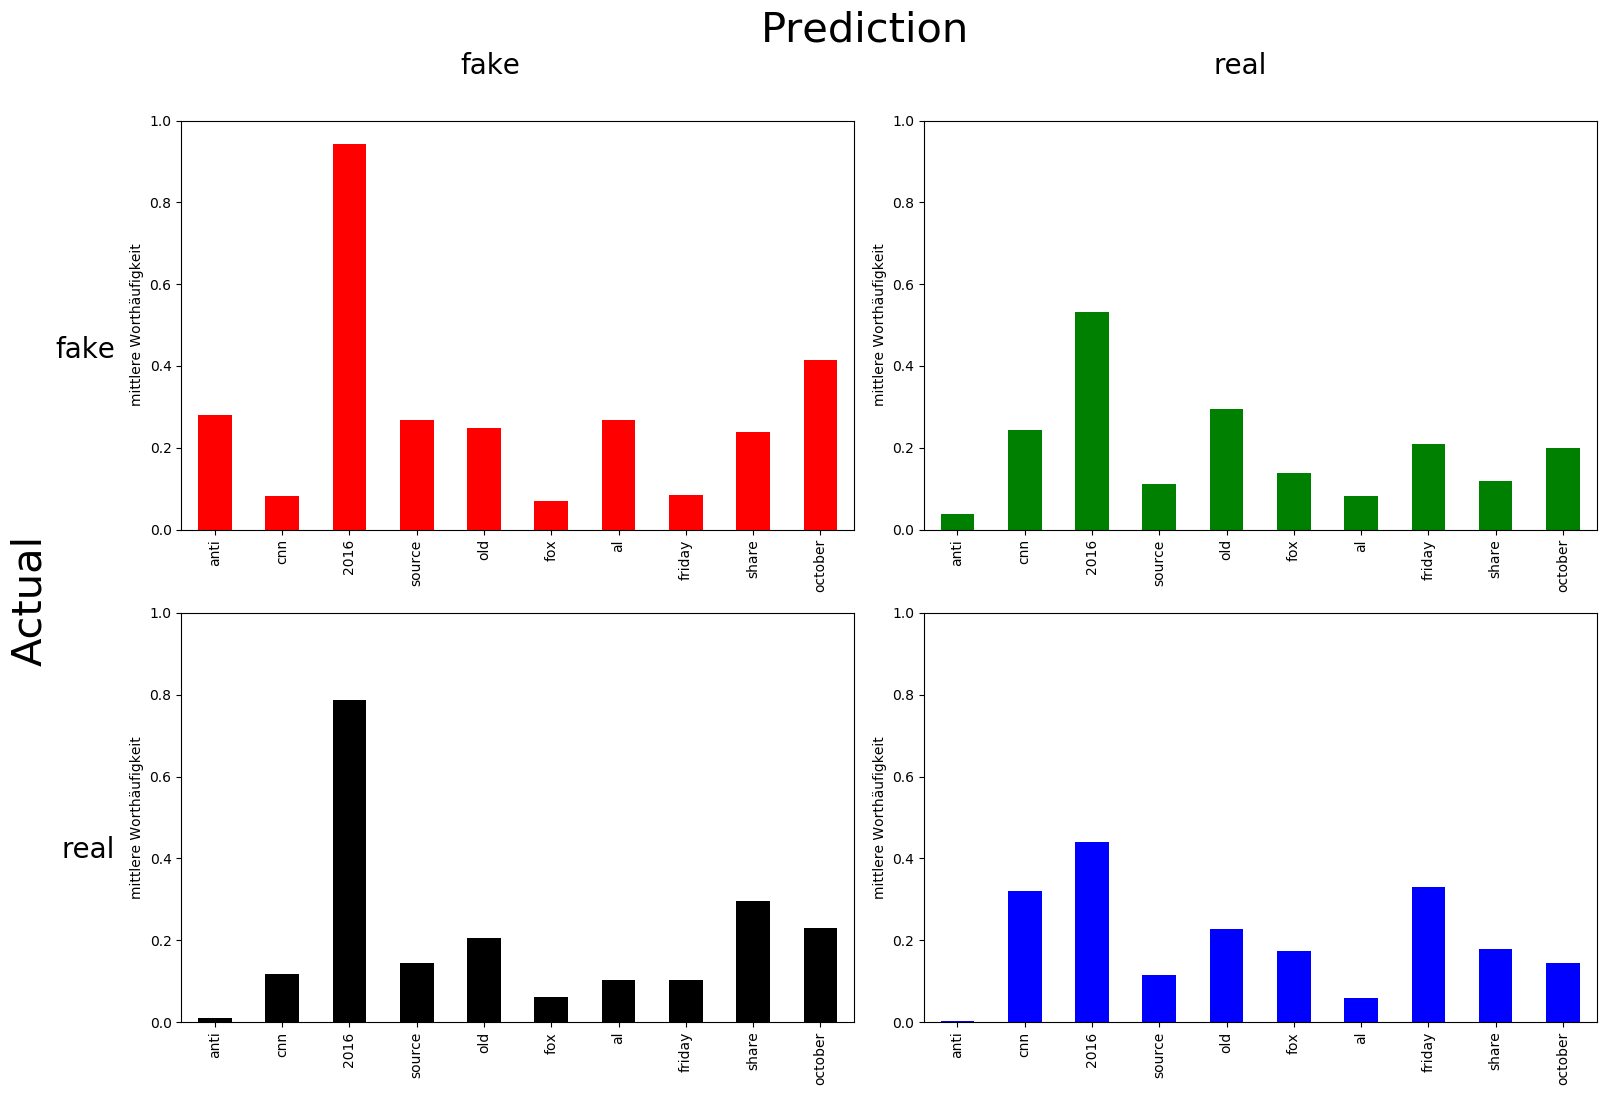

In [13]:
sorted_weights = first_weightsum.sort_values(ascending=False)
best_words = sorted_weights[:10].index

fig = plt.figure(figsize=(15,10),dpi=100)

ax = plt.subplot(2, 2, 1)
(X_TN[best_words].sum()/X_TN.shape[0]).plot(kind='bar',label="TN",color='r')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

ax = plt.subplot(2, 2, 2)
(X_FP[best_words].sum()/X_FP.shape[0]).plot(kind='bar',label="FP",color='g')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

ax = plt.subplot(2, 2, 3)
(X_FN[best_words].sum()/X_FN.shape[0]).plot(kind='bar',label="FN",color='k')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

plt.subplot(2, 2, 4)
(X_TP[best_words].sum()/X_TP.shape[0]).plot(kind='bar',label="TP",color='b')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)
    
plt.figtext(0.5, 1.09, r"Prediction", {'fontsize': 30},
     horizontalalignment='center',
     verticalalignment='top')
plt.figtext(0.25, 1.02, r"fake", {'fontsize': 20},
     horizontalalignment='center',
     verticalalignment='bottom',)
plt.figtext(0.75, 1.02, r"real", {'fontsize': 20},
     horizontalalignment='center',
     verticalalignment='bottom',)
    
plt.figtext(-0.07, 0.5, r"Actual", {'fontsize': 30},
     horizontalalignment='left',
     verticalalignment='center',
     rotation=90)
plt.figtext(0.00, 0.75, r"fake", {'fontsize': 20},
     horizontalalignment='right',
     verticalalignment='center',)
plt.figtext(0.00, 0.25, r"real", {'fontsize': 20},
     horizontalalignment='right',
     verticalalignment='center',)
    
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#plt.savefig("../build/plots/bow/cnfn_hist.pdf", bbox_inches = 'tight')
plt.close()

### RF Vergleichsmodell
Training einer RF auf dem bow Input und Evaluierung

In [6]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0,criterion='entropy')
RF.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [7]:
y_pred_bool_RF = RF.predict(X_test)
y_pred_RF = RF.predict_proba(X_test)
y_pred_RF = y_pred_RF[:,1]
y_pred_train_RF = RF.predict_proba(X_train)
y_pred_train_RF = y_pred_train_RF[:,1]

In [8]:
print(classification_report(Y_test, y_pred_bool_RF))
print(confusion_matrix(Y_test, y_pred_bool_RF,labels=[0,1]))

#Confusion Matrix
cnfn_matrix = pd.crosstab(Y_test, y_pred_bool_RF, rownames=['Actual'], colnames=['Predicted'])
print(cnfn_matrix)
cnfn_matrix.columns = ['fake','real']
cnfn_matrix = cnfn_matrix.rename_axis("Predicted", axis="columns")
cnfn_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
cnfn_matrix = cnfn_matrix/Y_test.shape[0]
sn.heatmap(cnfn_matrix, annot=True , cmap='viridis')
#plt.show()
plt.savefig("../build/plots/bow/RF/cnfsn_mtx_bow_best_nn.pdf")
plt.close()

#Overtraining test
bin_edges = np.linspace(0,1,11)
plt.hist(y_pred_RF[Y_test == 0],label="fake test", alpha = 0.4, color = "r",density=True,bins=bin_edges)
plt.hist(y_pred_train_RF[Y_train == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True,bins=bin_edges)
plt.hist(y_pred_RF[Y_test == 1],label = "real test",alpha = 0.4, color = "b",density=True,bins=bin_edges)
plt.hist(y_pred_train_RF[Y_train == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True,bins=bin_edges)

plt.xlabel("Prediction Probability")
plt.ylabel("density")
plt.legend(loc='upper center')
#plt.show()
plt.savefig("../build/plots/bow/RF/prob_bow_best_nn.pdf")
plt.close()

fpr_RF = dict()
tpr_RF = dict()
roc_auc_RF = dict()
fpr_RF, tpr_RF, _ = roc_curve(Y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.figure()
lw = 2
plt.plot(fpr_RF, tpr_RF, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/RF/roc_Hyperopt_bow_best_nn.pdf")
plt.close()

              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81      3650
         1.0       0.83      0.92      0.87      4714

   micro avg       0.85      0.85      0.85      8364
   macro avg       0.85      0.84      0.84      8364
weighted avg       0.85      0.85      0.85      8364

[[2762  888]
 [ 380 4334]]
Predicted   0.0   1.0
Actual               
0.0        2762   888
1.0         380  4334


### Comparison
Vergleich des Sequential mit dem RF in der ROC Curve

In [9]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Sequential (area = %0.2f)' % roc_auc)
plt.plot(fpr_RF, tpr_RF, color='darkred',
         lw=lw, label='RandomForest (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/roc_comparison.pdf")
plt.close()